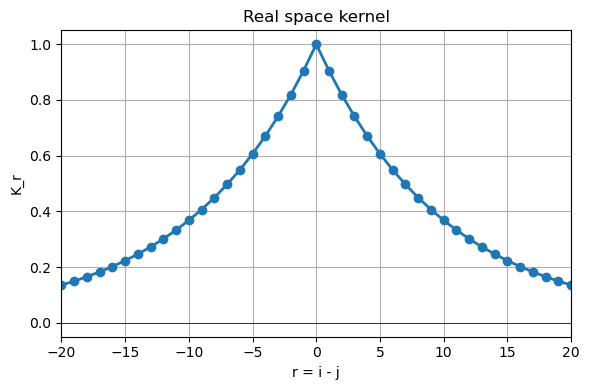

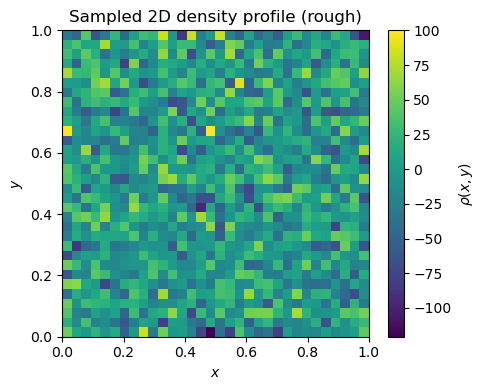

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ewaldnn2d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"
N_batch = 100
N_epochs = 10000
lr = 1e-1 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 500    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # in this example, we use reflective padding for local feature generation
N_pow = 1 # number of local features per grid point
N_train = 1500
N_test = 250
N_val = 250

# grid and basis settings
N_x = 32 # number of grid points in x direction
N_y = N_x # number of grid points in y direction
m_x = torch.arange(0, N_x, dtype=dtype, device=device)             # (N_x,)
m_y = torch.arange(0, N_y, dtype=dtype, device=device)             # (N_y,)
abs_val = torch.sqrt(m_x[:, None]**2 + m_y[None, :]**2)  # (M_x, M_y)
x = torch.linspace(0, 1, N_x, dtype=dtype, device=device)            # (N_x,)
y = torch.linspace(0, 1, N_y, dtype=dtype, device=device)            # (N_y,)
DM_x = torch.cos(torch.pi * torch.outer(m_x, x))                  # (M_x, N_x)
DM_y = torch.cos(torch.pi * torch.outer(m_y, y))                  # (M_y, N_y)
DerDM_x = -torch.pi * m_x[:, None] * torch.sin(torch.pi * torch.outer(m_x, x))  # (M_x, N_x) # derivative of design matrix
DerDM_y = -torch.pi * m_y[:, None] * torch.sin(torch.pi * torch.outer(m_y, y))  # (M_y, N_y) # derivative of design matrix

data_regime = "rough" # "smooth" or "rough"
if data_regime == "smooth":
    M_cutoff = 10 # maximum harmonic   
    std_harm = 2.0 / (1.0 + 0.2 * abs_val)**2 * (abs_val <= M_cutoff).double()  # (M_x, M_y)
elif data_regime == "rough":
    std_harm = 2.0 / (1.0 + 0.0 * abs_val)**2 # (M_x, M_y)
else:
    raise ValueError("regime must be 'smooth' or 'rough'")
std_harm[0, 0] = 0.0 # no uniform density offset

# interaction kernel parameters
kernel_regime = "exp"  # "power", "yukawa", or "exp", or "custom"
lam = 10.0
alpha = 1.0
xi = 10.0
amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy

# define total energy function based on selected kernel regime
if kernel_regime == "power":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return E_int_rs_dct(rho, kernel="power", alpha=alpha)
elif kernel_regime == "yukawa": 
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return E_int_rs_dct(rho, kernel="yukawa", lam=lam)
elif kernel_regime == "exp":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return E_int_rs_dct(rho, kernel="exp", xi=xi)
elif kernel_regime == "custom":
    def E_tot(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor) -> torch.Tensor:
        return E_int_rs_dct(rho, kernel="exp", xi=xi) + \
                amp_Gaussian_1 * E_int_rs_dct(rho, kernel="gaussian", sigma=sigma_Gaussian_1, pad_mode="reflect") + \
                amp_Gaussian_2 * E_int_rs_dct(rho, kernel="gaussian", sigma=sigma_Gaussian_2, pad_mode="reflect")
    
# generate train/test split
flag_generate_data = True # if True, generate new data; if False, load existing data from disk
if flag_generate_data:
    N_batch_int = 10
    torch.manual_seed(1234) # for reproducibility
    rho_train, d_rho_x_train, d_rho_y_train, a_train, targets_train = generate_data_2d(N_train, N_batch_int, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)
    rho_test, d_rho_x_test, d_rho_y_test, a_test, targets_test = generate_data_2d(N_test, N_batch_int, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
    rho_val, d_rho_x_val, d_rho_y_val, a_val, targets_val = generate_data_2d(N_val, N_batch_int, E_tot, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)  
    # save data to disk
    os.makedirs("DATA2d", exist_ok=True)
    
    if kernel_regime == "power":
        fname = f"DATA2d/dataset_{data_regime}_{kernel_regime}_{alpha}_{N_x}_{N_y}.pt"
    elif kernel_regime == "yukawa":
        fname = f"DATA2d/dataset_{data_regime}_{kernel_regime}_{lam}_{N_x}_{N_y}.pt"
    elif kernel_regime == "exp":
        fname = f"DATA2d/dataset_{data_regime}_{kernel_regime}_{xi}_{N_x}_{N_y}.pt"
    elif kernel_regime == "custom":
        fname = f"DATA2d/dataset_{data_regime}_{kernel_regime}_{N_x}_{N_y}.pt"
    else:
        raise ValueError(f"Unknown kernel_regime: {kernel_regime}")

    torch.save(
        {
            "rho_train": rho_train,
            "d_rho_x_train": d_rho_x_train,
            "d_rho_y_train": d_rho_y_train,
            "a_train": a_train,
            "targets_train": targets_train,
            "rho_val": rho_val,
            "d_rho_x_val": d_rho_x_val,
            "d_rho_y_val": d_rho_y_val,
            "a_val": a_val,
            "targets_val": targets_val,
            "rho_test": rho_test,
            "d_rho_x_test": d_rho_x_test,
            "d_rho_y_test": d_rho_y_test,
            "a_test": a_test,
            "targets_test": targets_test,
            "data_regime": data_regime,
            "kernel_regime": kernel_regime,
        },
        fname,
    )
else:
    # load data from disk
    if kernel_regime == "power":
        data = torch.load(f"DATA2d/dataset_{data_regime}_{kernel_regime}_{alpha}_{N_x}_{N_y}.pt")
    elif kernel_regime == "yukawa":
        data = torch.load(f"DATA2d/dataset_{data_regime}_{kernel_regime}_{lam}_{N_x}_{N_y}.pt")
    elif kernel_regime == "exp":
        data = torch.load(f"DATA2d/dataset_{data_regime}_{kernel_regime}_{xi}_{N_x}_{N_y}.pt")
    elif kernel_regime == "custom":
        data = torch.load(f"DATA2d/dataset_{data_regime}_{kernel_regime}_{N_x}_{N_y}.pt")
    rho_train = data["rho_train"]
    targets_train = data["targets_train"]
    rho_test = data["rho_test"]
    targets_test = data["targets_test"]
    rho_val = data["rho_val"]
    targets_val = data["targets_val"]

features_train = generate_loc_features_rs(rho_train, N_pow=N_pow)  # (N_train, N_x, N_y, N_feat)
features_test  = generate_loc_features_rs(rho_test, N_pow=N_pow)   # (N_test, N_x, N_y, N_feat)
features_val   = generate_loc_features_rs(rho_val, N_pow=N_pow)    # (N_val, N_x, N_y, N_feat)

# Normalize features
mean_feat, std_feat = compute_normalization_stats(features_train)
features_train_norm = normalize_features(features_train, mean_feat, std_feat)
features_test_norm = normalize_features(features_test, mean_feat, std_feat)
features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# Normalize targets
E_mean = targets_train.mean()
E_std = targets_train.std()
targets_train_norm = (targets_train - E_mean) / E_std
targets_test_norm = (targets_test - E_mean) / E_std
targets_val_norm = (targets_val - E_mean) / E_std

# Datasets
train_dataset = TensorDataset(features_train_norm, targets_train_norm)
val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)


# visualize the interaction kernel
R = 20 
r_grid = torch.arange(-R, R+1)
plt.figure(figsize=(6,4))
if kernel_regime == "yukawa":
    plt.plot(r_grid, K_yukawa(r_grid, lam=lam), 'o-', linewidth=2) 
elif kernel_regime == "power":
    plt.plot(r_grid, K_power(r_grid, alpha=alpha), 'o-', linewidth=2) 
elif kernel_regime == "exp":
    plt.plot(r_grid, K_exp(r_grid, xi=xi), 'o-', linewidth=2)
elif kernel_regime == "custom":
    K_r = K_exp(r_grid, xi=xi) + \
          amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + \
          amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2)
    plt.plot(r_grid, K_r, 'o-', linewidth=2)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(-R, R)
# plt.ylim((0.0, 1.0))
plt.title(f"Real space kernel")
plt.grid(True)
plt.tight_layout()
plt.show()

# visualize a sampled density profile
rho_batch, _, _ , a_batch = sample_density_batch(N_batch, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
rho_np = rho_batch[0, :, :].detach().cpu().numpy()
plt.figure(figsize=(5, 4))
im = plt.imshow(
    rho_np.T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$\rho(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
if data_regime == "rough":
    plt.title("Sampled 2D density profile (rough)")
elif data_regime == "smooth":
    plt.title("Sampled 2D density profile (smooth)")
plt.tight_layout()
plt.show()

In [5]:
ckpt_dir = "LearningNonLocalKernel2d_wDCTKernel_checkpoints"
flag_train = True  # set to True to train models
learning_regime = "dct_rs_blind" # "dct_rs_blind", "dct_exp_rs_mixture", "dct_ms_blind", "dct_coulomb"
n_exp_components = 1  # for hybrid

if data_regime == "smooth":
    range_ms = M_cutoff  # for dct_ms_blind
else:
    range_ms = N_x - 1  # for dct_ms_blind

if kernel_regime == "exp":
            run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_xi{xi}" + learning_regime
elif kernel_regime == "yukawa":
    run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_lam{lam}" + learning_regime
elif kernel_regime == "power":
    run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + f"_alpha{alpha}" + learning_regime
elif kernel_regime == "custom":
    run_name = f"rs_dct_kernel_" + data_regime + '_' + kernel_regime + '_' + learning_regime

if flag_train:

    torch.manual_seed(1234) # for reproducibility
    
    if learning_regime == "dct_rs_blind":
        model = DCTKernelEnergyNN(
            N_x=N_x,
            N_y=N_y,
            learning_mode="dct_rs_blind",
            zero_r_flag=False,   # or True if you want K_0=0
            mean_feat=mean_feat,
            std_feat=std_feat,
            E_mean=E_mean,
            E_std=E_std,
        ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Reduce LR when val loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=50, cooldown=2, min_lr=1e-6
    )

    hist, best_epoch = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        max_epochs=N_epochs,
        patience=patience,
        min_delta=min_delta,
        ckpt_dir=ckpt_dir,
        run_name=run_name,
        learning_regime=learning_regime,
        N_x=N_x,
        N_y=N_y,
        device=device,
    )

[0001] train=1.830631 | val=0.958192 | best_val=0.958192 (epoch 1)
[0010] train=0.051046 | val=0.064073 | best_val=0.064073 (epoch 10)
[0020] train=0.294159 | val=0.349581 | best_val=0.051872 (epoch 12)
[0030] train=0.843051 | val=0.788139 | best_val=0.051872 (epoch 12)
[0040] train=0.358210 | val=0.304165 | best_val=0.051872 (epoch 12)
[0050] train=0.273988 | val=0.268364 | best_val=0.051872 (epoch 12)
[0060] train=0.177724 | val=0.165290 | best_val=0.051872 (epoch 12)
[0070] train=0.002222 | val=0.004642 | best_val=0.004642 (epoch 70)
[0080] train=0.000170 | val=0.000895 | best_val=0.000895 (epoch 80)
[0090] train=0.000066 | val=0.000335 | best_val=0.000340 (epoch 89)
[0100] train=0.000031 | val=0.000140 | best_val=0.000130 (epoch 99)
[0110] train=0.000013 | val=0.000054 | best_val=0.000063 (epoch 108)
[0120] train=0.000006 | val=0.000021 | best_val=0.000025 (epoch 117)
[0130] train=0.000007 | val=0.000010 | best_val=0.000013 (epoch 126)
[0140] train=0.000032 | val=0.000045 | best_va

   epoch  train_loss  val_loss
0      1    1.830631  0.958192
1      2    0.806393  0.615429
2      3    0.369939  0.215981
3      4    0.225327  0.194826
4      5    0.125049  0.118390


<Axes: title={'center': 'rs_dct_kernel_rough_exp_xi10.0dct_rs_blind'}, xlabel='epoch'>

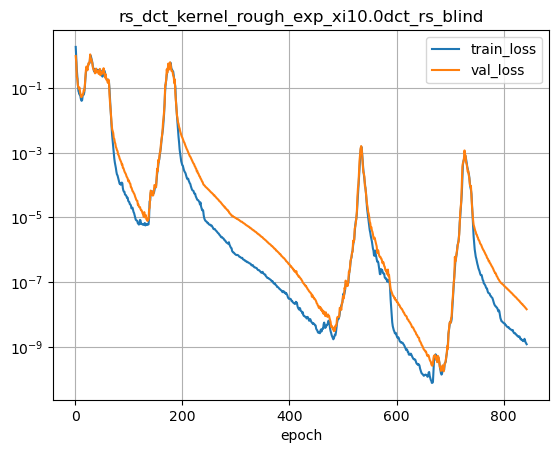

In [6]:
path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

/var/folders/7y/2nyql_3x31bc9826lvy4g2t40000gn/T/ipykernel_23910/2544674867.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lam_K_full = kernel_eigenvals_dct(torch.tensor(k_full, dtype=dtype))


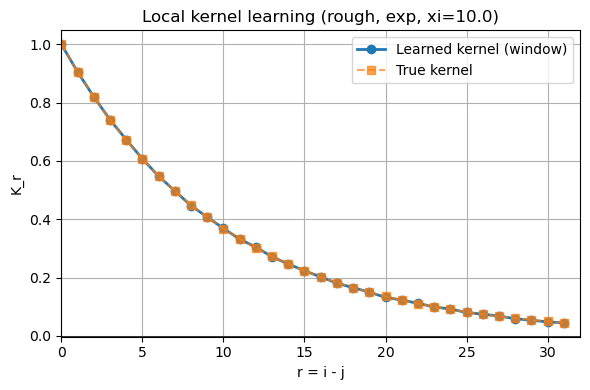

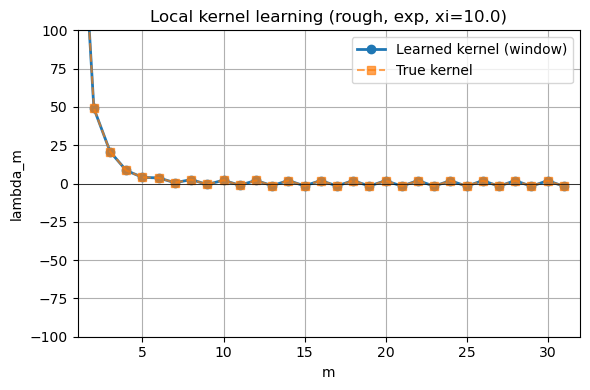

In [7]:
model, normalization, epoch, val_loss = load_checkpoint(
        ckpt_dir + f"/{run_name}_best.pt",
        DCTKernelEnergyNN,
        device=device
    )

if learning_regime == "dct_rs_blind":
    with torch.no_grad():
        k_full = (model.nonlocal_kernel.rs_kernel * model.nonlocal_kernel.rs_mask).to(device=device, dtype=dtype)

if kernel_regime == "exp":
    def K_true(r):
        return np.exp(-np.abs(r) / xi)
elif kernel_regime == "yukawa":
    def K_true(r):
        r_abs = np.abs(r)
        out = np.exp(-r_abs / lam) / np.maximum(r_abs, 1.0)
        return out * (r_abs > 0)
elif kernel_regime == "power":
    def K_true(r):
        r_abs = np.abs(r)
        out = 1.0 / (np.maximum(r_abs, 1.0)**alpha)
        return out * (r_abs > 0)    
elif kernel_regime == "custom":
    def K_true(r):
        r_abs = np.abs(r)
        out = np.exp(-r_abs / xi) + \
              amp_Gaussian_1 * np.exp(- (r_abs**2) / (sigma_Gaussian_1**2)) + \
              amp_Gaussian_2 * np.exp(- (r_abs**2) / (sigma_Gaussian_2**2))
        return out 



r_grid = np.arange(0, N_x)

x_vals = torch.arange(0, N_x, device=device, dtype=dtype)     # (N_x,)
y_vals = torch.arange(0, N_y, device=device, dtype=dtype)     # (N_y,)
r_vals = torch.sqrt(x_vals.view(-1, 1) ** 2 + y_vals.view(1, -1) ** 2)  # (N_x, N_y)

k_true = K_true(r_vals).to(device=device, dtype=dtype)  # (N_x, N_y)
lam_K_true = kernel_eigenvals_dct(k_true).to(device=device, dtype=dtype)  # (N_x, N_y)
# lam_K_true[0, 0] = 0.0  # enforce zero mode
k_true = kernel_from_eigenvals_dct(lam_K_true).cpu().numpy()

lam_K_full = kernel_eigenvals_dct(torch.tensor(k_full, dtype=dtype))
lam_K_full[0, 0] = lam_K_true[0, 0] #0.0  # enforce zero mode
k_full = kernel_from_eigenvals_dct(lam_K_full).cpu().numpy()

plt.figure(figsize=(6,4))
plt.plot(r_grid, k_full[:, 0], 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, k_true[:, 0], 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("r = i - j")
plt.ylabel("K_r")
plt.xlim(0, 32)
# plt.ylim((-0.01, 0.01))
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, power, alpha={alpha})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(r_grid, lam_K_full[:, 0], 'o-', label='Learned kernel (window)', linewidth=2)
plt.plot(r_grid, lam_K_true[:, 0], 's--', label='True kernel', alpha=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.xlabel("m")
plt.ylabel("lambda_m")
plt.xlim(1, 32)
plt.ylim((-100.0, 100.0))
plt.legend()
plt.grid(True)
if kernel_regime == "exp":
    plt.title(f"Local kernel learning ({data_regime}, exp, xi={xi})")
elif kernel_regime == "yukawa":
    plt.title(f"Local kernel learning ({data_regime}, yukawa, lam={lam})")
elif kernel_regime == "power":
    plt.title(f"Local kernel learning ({data_regime}, power, alpha={alpha})")
elif kernel_regime == "custom":
    plt.title(f"Local kernel learning ({data_regime}, custom kernel)")
plt.tight_layout()
plt.show()



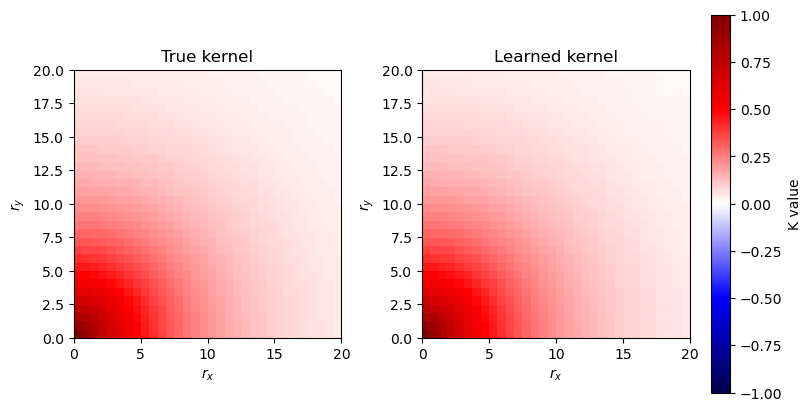

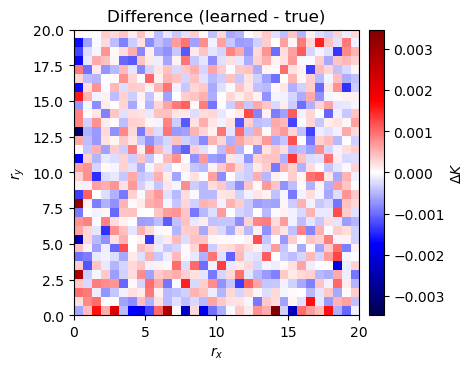

In [14]:
# 2D visualization of learned vs true kernel - real space
coords = torch.arange(0, N_x, device=device, dtype=dtype)  # [0, ..., N_x-1]
rx, ry = torch.meshgrid(coords, coords, indexing="ij")      # (N_x, N_x)
r = torch.sqrt(rx**2 + ry**2)                               # radial distance
K_true_2d = K_true(r)                                       # (N_x, N_x)

K_true_np = K_true_2d.detach().cpu().numpy()
K_diff_np  = (k_full - K_true_np)

# symmetric color scale for fair comparison
R = 20
vmax = max(np.abs(K_true_np).max(), np.abs(k_full).max())
vmax_diff = np.abs(K_diff_np).max()
extent = [0, R, 0, R]

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    constrained_layout=True  # lets matplotlib handle spacing nicely
)

# --- True kernel ---
im0 = axes[0].imshow(
    K_true_np,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[0].set_title("True kernel")
axes[0].set_xlabel(r"$r_x$")
axes[0].set_ylabel(r"$r_y$")

# --- Learned kernel ---
im1 = axes[1].imshow(
    k_full,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[1].set_title("Learned kernel")
axes[1].set_xlabel(r"$r_x$")
axes[1].set_ylabel(r"$r_y$")

cbar = fig.colorbar(
    im1,
    ax=axes,
    location="right",
    fraction=0.04,  # width
    pad=0.02         # distance from rightmost axes
)
cbar.set_label("K value")

plt.show()

fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(
    K_diff_np,
    origin="lower",
    extent=extent,
    vmin=-np.abs(K_diff_np).max(),
    vmax= np.abs(K_diff_np).max(),
    cmap="seismic"
)
ax.set_title("Difference (learned - true)")
ax.set_xlabel(r"$r_x$")
ax.set_ylabel(r"$r_y$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\Delta K$")

plt.show()

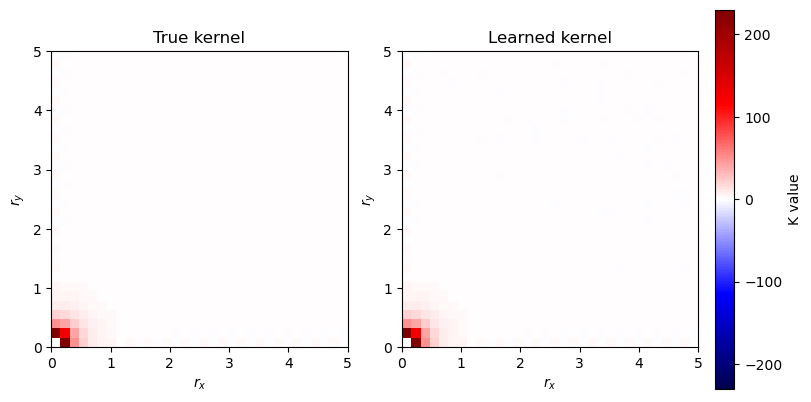

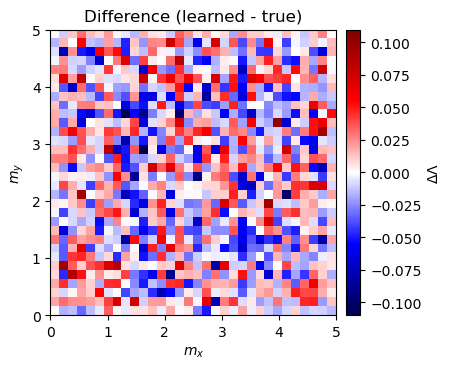

In [ ]:
# 2D visualization of learned vs true kernel - momentum space
coords = torch.arange(0, N_x, device=device, dtype=dtype)  # [0, ..., N_x-1]
mx, my = torch.meshgrid(coords, coords, indexing="ij")      # (N_x, N_x)
m = torch.sqrt(mx**2 + my**2)                               # radial distance

Lam_true_np = lam_K_true.detach().cpu().numpy()
Lam_true_np[0, 0] = 0.0
lam_K_full[0, 0] = 0.0
Lam_diff_np  = (lam_K_full - Lam_true_np)

# symmetric color scale for fair comparison
M = 5
vmax = max(np.abs(Lam_true_np).max(), np.abs(lam_K_full).max())
vmax_diff = np.abs(Lam_diff_np).max()
extent = [0, M, 0, M]

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    constrained_layout=True  # lets matplotlib handle spacing nicely
)

# --- True kernel ---
im0 = axes[0].imshow(
    Lam_true_np,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[0].set_title("True kernel")
axes[0].set_xlabel(r"$m_x$")
axes[0].set_ylabel(r"$m_y$")

# --- Learned kernel ---
im1 = axes[1].imshow(
    lam_K_full,
    origin="lower",
    extent=extent,
    vmin=-vmax, vmax=vmax,
    cmap="seismic"
)
axes[1].set_title("Learned kernel")
axes[1].set_xlabel(r"$m_x$")
axes[1].set_ylabel(r"$m_y$")

cbar = fig.colorbar(
    im1,
    ax=axes,
    location="right",
    fraction=0.04,  # width
    pad=0.02         # distance from rightmost axes
)
cbar.set_label("K value")

plt.show()

fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(
    Lam_diff_np,
    origin="lower",
    extent=extent,
    vmin=-np.abs(Lam_diff_np).max(),
    vmax= np.abs(Lam_diff_np).max(),
    cmap="seismic"
)
ax.set_title("Difference (learned - true)")
ax.set_xlabel(r"$m_x$")
ax.set_ylabel(r"$m_y$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"$\Delta \Lambda$")

plt.show()